## Approach Taken
- Load the data 
- Understand the data using data dictionary 
- Perform data cleanup and handle missing data and outliers 
- EDA and data deep dive & Plotting data 
- Identify the features and Model building 
    - train test split 
    - fit model 
    - analysis of summary stats 
    - 


### Importing required packages 

In [1771]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1772]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
# Check the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
import warnings
from sklearn.preprocessing import power_transform
warnings.filterwarnings("ignore")


### Data Dictionary 

	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [2047]:
df = pd.read_csv('F:\\2020\\MS_DataScience\\Machine Learning - Module 1\\Linear Regression\\Submission\\day.csv', parse_dates=['dteday'],dayfirst=True)

In [2048]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [2049]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null datetime64[ns]
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(11)
memory usage: 91.4 KB


In [2050]:
# Get the Month, Days and Year appropriately
df['month_name'] = df.dteday.dt.month_name()
df['day'] = df.dteday.dt.day_name()
df['year'] = df.dteday.dt.year

In [2051]:
# Convert appropriately the categorical variable by adding two new columns as 
# Working day - into daytype as Weekend, Holiday , Long_weekend , Working_day
def working_day(holiday,weekday):
    if (weekday == 1 or weekday == 5) and holiday == 1:
        return 'LongWeekend'
    elif weekday == 0 or weekday == 6:
        return 'Weekend'
    elif (weekday != 1 or weekday != 5) and holiday == 1:
        return 'Holiday'
    else:
        return 'Working'

df['daytype'] = df[['holiday','weekday']].apply(lambda x:working_day(x.holiday,x.weekday), axis=1)

In [2052]:
#calculate feature days since launch (assuming 1st Jan 2018)
def day_since_start(dt,srt_dt=datetime.date(2018,1,1)):
    return dt.date() - srt_dt

In [2053]:
df['day_since_strt'] = df.dteday.apply(lambda x:day_since_start(x))
df['day_since_strt'] = df['day_since_strt'].dt.days.astype('int16')

In [2054]:
def day_of_yr(year,dt):
    if year == 2018:
        srt_dt = datetime.date(2018,1,1)
    else:
        srt_dt = datetime.date(2019,1,1)
    return dt.date() - srt_dt

In [2055]:
# adding a feature day of year .
df['day_of_yr'] = df.dteday.apply(lambda x:day_of_yr(x.year,x))
df['day_of_yr'] = df['day_of_yr'].dt.days.astype('int16')

In [2056]:
# weathersit into weather 1=Clear, 2=Mist_Cloudy,3=Light_Snow_Rain,4=Heavy_Rain_Hail 
df['weather'] = df.weathersit.map({1:'Clear', 2:'Mist_Cloudy',3:'Light_Snow_Rain',4:'Light_Snow_Rain'})
# season = 1:spring, 2:summer, 3:fall, 4:winter
df['season'] = df.season.map({1:'spring',2:'summer', 3:'fall', 4:'winter'})

In [2065]:
#Creating a feature to add a perceived temp diff (trying to also treat outliars using power_transform..)
df['percvd_tmp_diff'] = df.atemp - df.temp
df['percvd_tmp_diff'] = power_transform(df[['percvd_tmp_diff']],method='yeo-johnson')

In [2130]:
# binning temp 
df['temp_rng'] = np.floor(df.temp)//5

In [2131]:
# binning windspeed 
df['wind_rng'] = np.floor(df.windspeed)//4

In [2132]:
#binning humidity 
df['hum_rng'] = np.floor(df.hum)//4

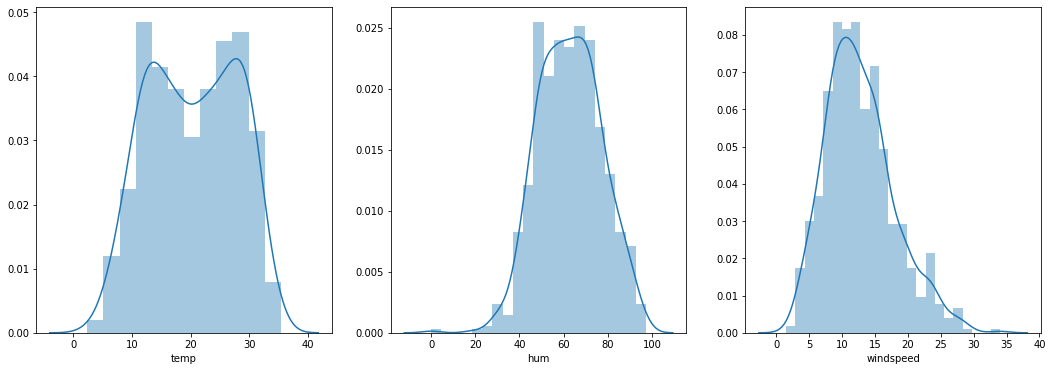

In [2138]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.distplot(df.temp)
plt.subplot(1,3,2)
sns.distplot(df.hum)
plt.subplot(1,3,3)
sns.distplot(df.windspeed)

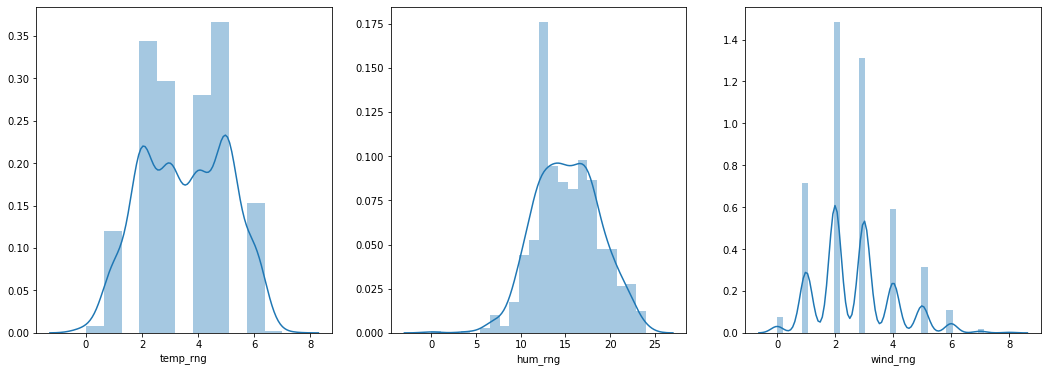

In [2140]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.distplot(df['temp_rng'])
plt.subplot(1,3,2)
sns.distplot(df['hum_rng'])
plt.subplot(1,3,3)
sns.distplot(df['wind_rng'])
plt.show()

Since binning is further impacting the normality of the data, we go with actual continuous variables , hum, windspeed and temp

In [2148]:
df01 = df[['instant', 'dteday','month_name','day', 'year','day_of_yr','day_since_strt','daytype', 'temp',
           'atemp', 'hum','weather','season',
           'windspeed','casual', 'registered',
           'cnt','percvd_tmp_diff','temp_rng','wind_rng','hum_rng']].copy(deep=True)

In [2149]:
var_categorical = ['month_name','day','daytype','weather','season']
var_numerical = ['temp','atemp','percvd_tmp_diff','hum','windspeed','casual','day_since_strt','registered','cnt']

## EDA to understand the data better 

### Bivariate analysis against the Target Variables (Numerical vs Categorical |  Numerical vs Numerical)
    - Numerical Vs Categorical
 Considering cnt as the target variable

In [2150]:
pf = pd.merge(df01[df01.year==2018][['year','day_of_yr','cnt']] , df01[df01.year==2019][['year','day_of_yr','cnt']],how='inner', on='day_of_yr')

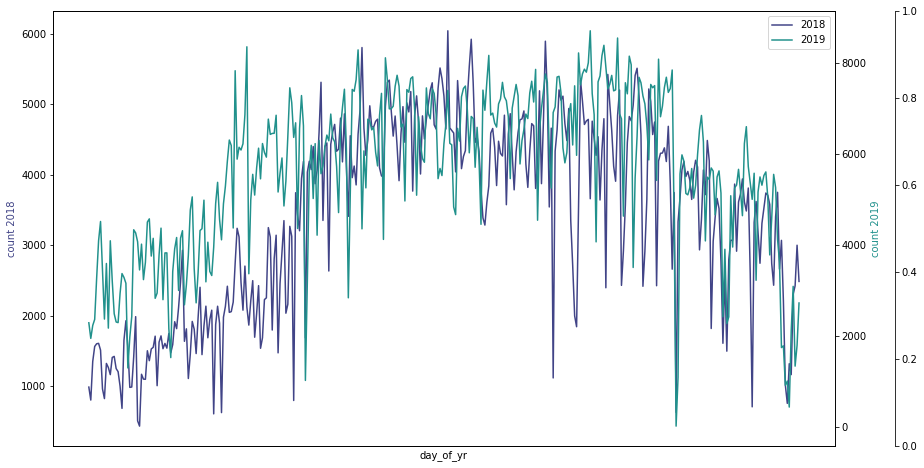

In [2340]:
# plot for usage count across days in 2018 and 2019. Trend/pattens over years.
fig = plt.figure(figsize=(14,8))
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()

host.set_xlabel("day_of_yr")
host.set_ylabel("count 2018")
par1.set_ylabel("count 2019")

color1 = plt.cm.viridis(0.2)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

p1, = host.plot(pf.day_of_yr,pf.cnt_x, color=color1,label="2018")
p2, = par1.plot(pf.day_of_yr,pf.cnt_y,color=color2, label="2019")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.show()

## Inferences
 - the usage trend follows mostly a similar pattern over the years 2018 and 2019. The peaks are different in 2019 precisely becuase the user base has gone up in 2019 as against 2018.


<Figure size 1296x864 with 0 Axes>

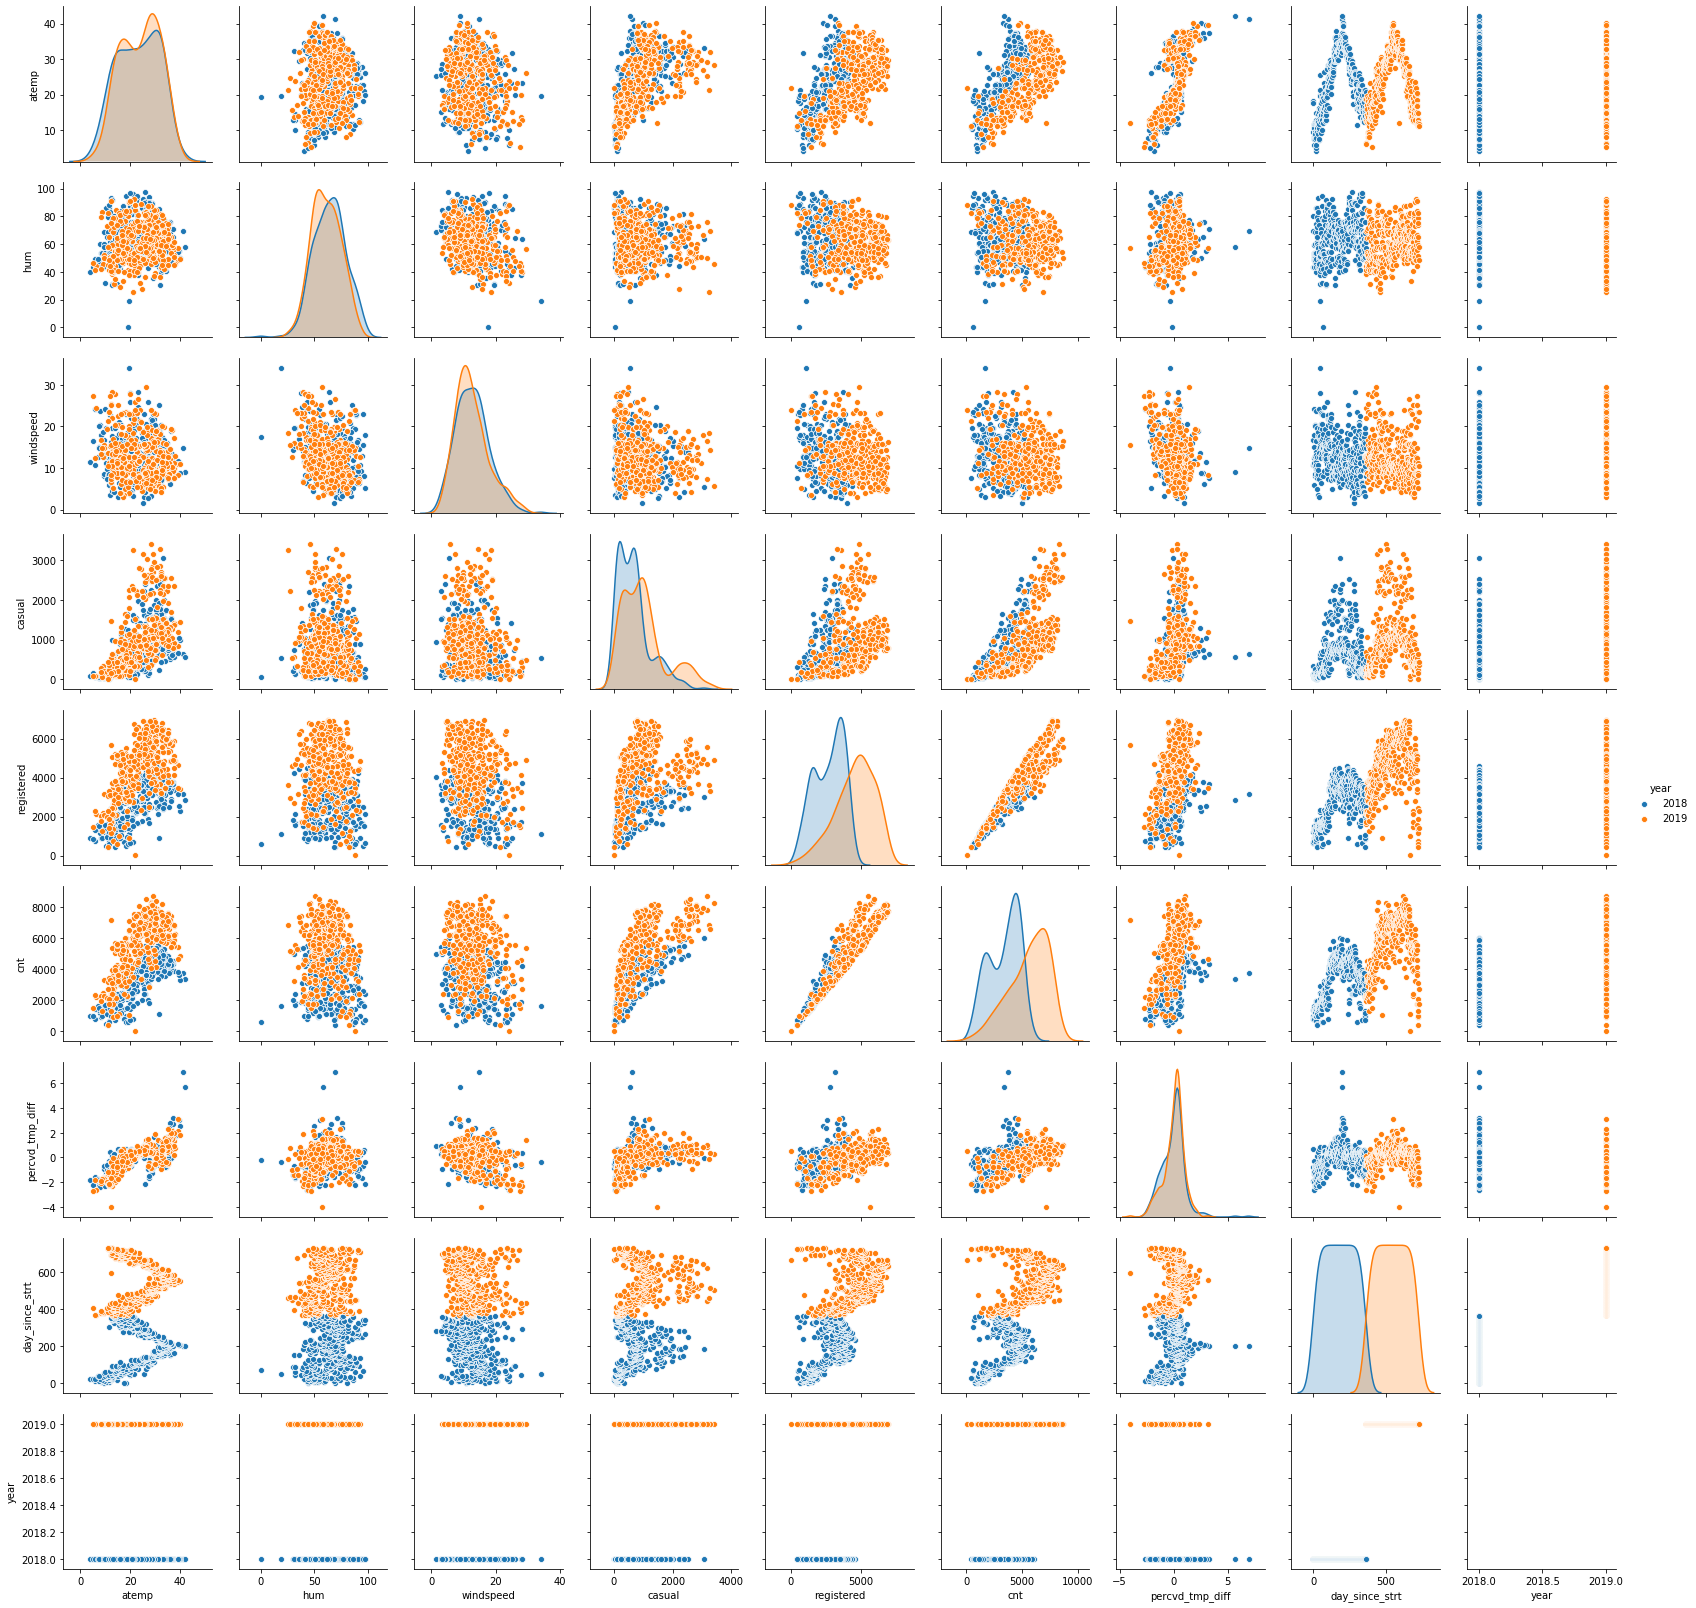

In [2153]:
plt.figure(figsize=(18,12))
d = df01[['atemp','hum','windspeed','casual','registered','cnt','percvd_tmp_diff','day_since_strt','year']]
sns.pairplot(data=d, hue='year')
plt.show()

## Inference(s)
 - there seems to be a obvious linear relationship between the ridership wrt to registerd user base, similary with casual users.
 - with Temparature (atemp, temp) also we see a linear relationship with rider count.
 - with increase in no of days in market we see increasing userbase with inturn increasing the ridership. 
 - the ridership shows an inceasing trend since start and with days since started however except towards the end of each year
 - Percieved temp difference i.e atemp - temp (feature variable) shows there is an increasing cnt with increase in diff. 
 - Evident that the cnt across yrs 2018 and 2019 gradually increases from Jan and drops towards the last 2-3 months in relation to the weather conditions. 

## BOXPLOT COUNT WRT TO SEASONS AND OTHER CATGORICAL VARIABLES (Y-O-Y)

In [2147]:
df01.head()

,instant,dteday,month_name,day,year,day_of_yr,day_since_strt,daytype,temp,atemp,hum,weather,season,windspeed,casual,registered,cnt,percvd_tmp_diff
0,1,2018-01-01,January,Monday,2018,0,0,Working,14.110847,18.18125,80.5833,Mist_Cloudy,spring,10.749882,331,654,985,0.679517
1,2,2018-01-02,January,Tuesday,2018,1,1,Working,14.902598,17.68695,69.6087,Mist_Cloudy,spring,16.652113,131,670,801,-0.774762
2,3,2018-01-03,January,Wednesday,2018,2,2,Working,8.050924,9.47025,43.7273,Clear,spring,16.636703,120,1229,1349,-1.933077
3,4,2018-01-04,January,Thursday,2018,3,3,Working,8.200000,10.60610,59.0435,Clear,spring,10.739832,108,1454,1562,-1.136667
4,5,2018-01-05,January,Friday,2018,4,4,Working,9.305237,11.46350,43.6957,Clear,spring,12.522300,82,1518,1600,-1.357033


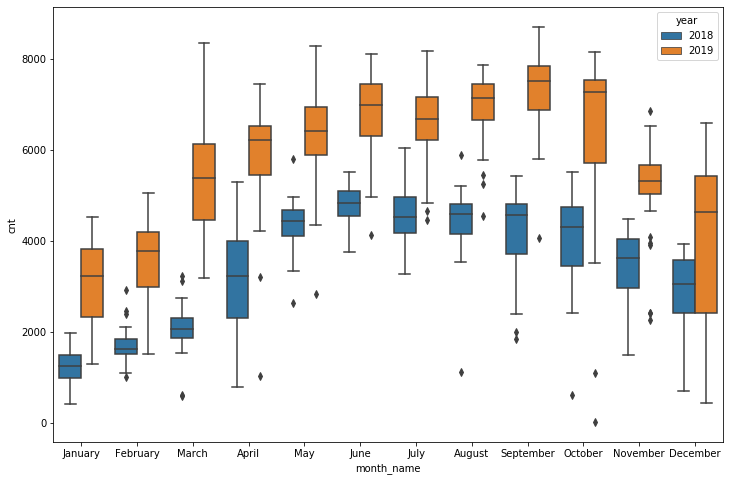

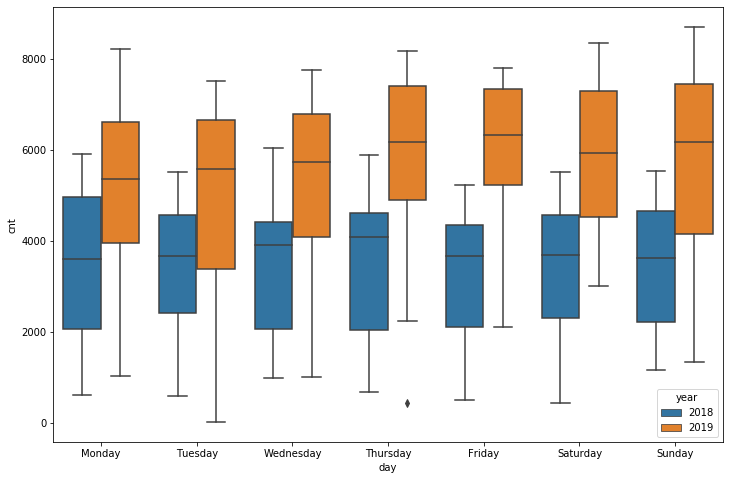

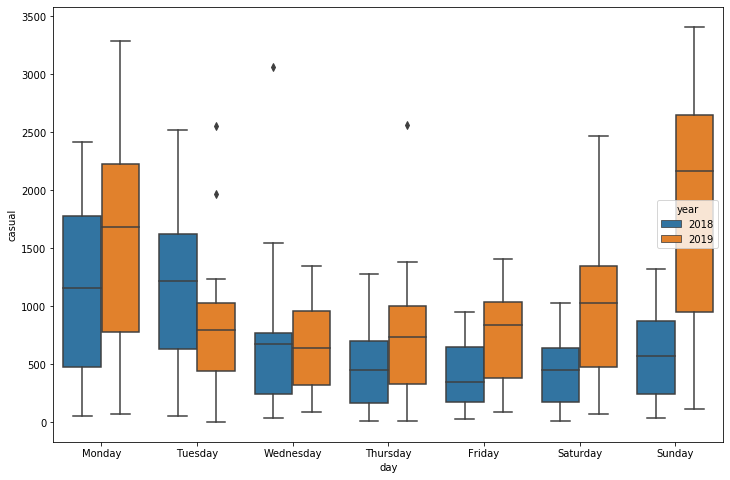

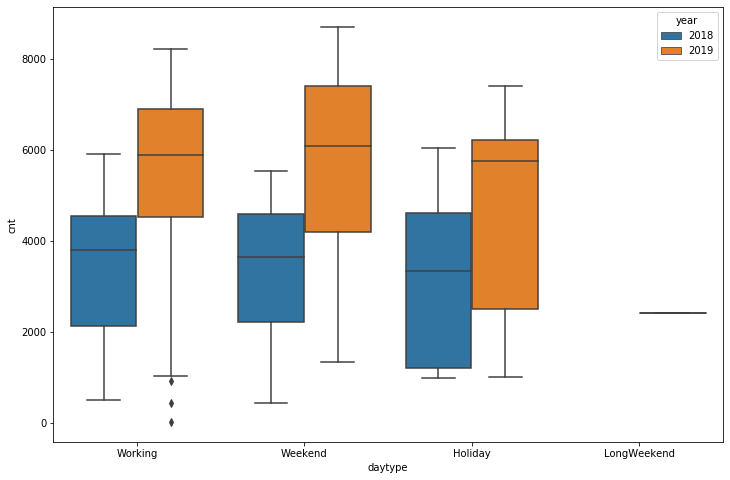

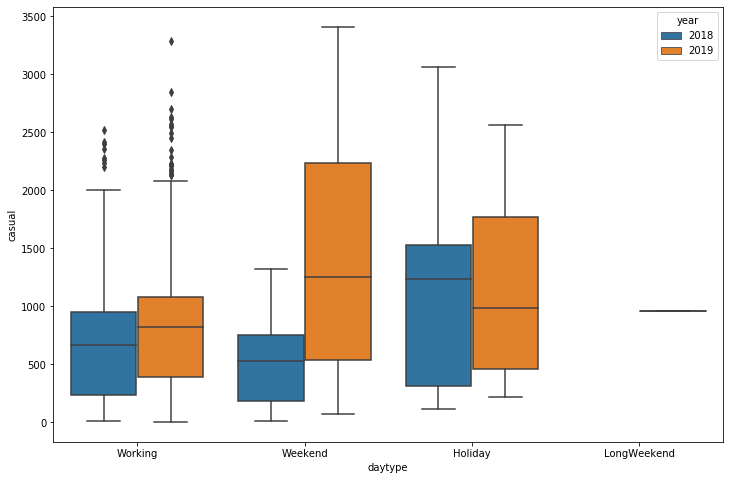

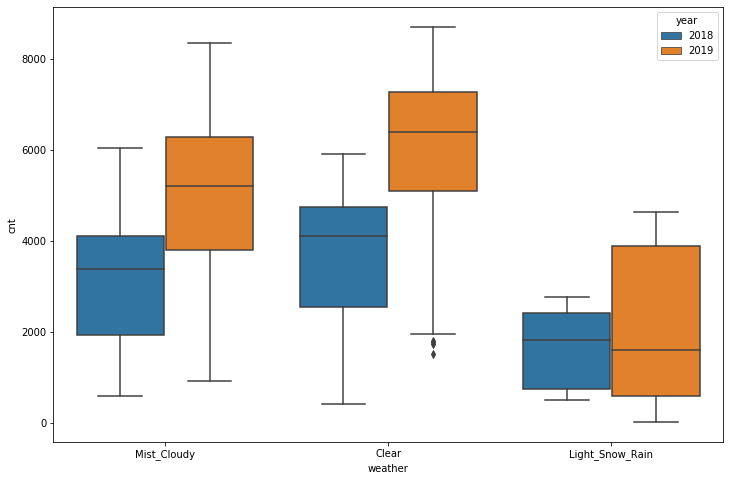

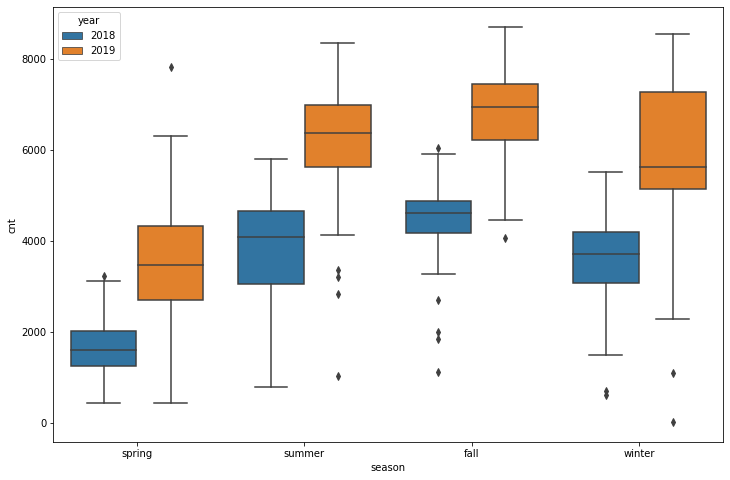

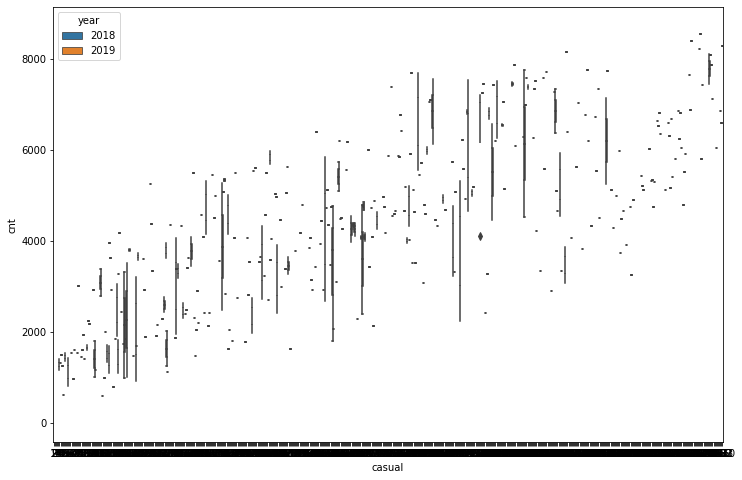

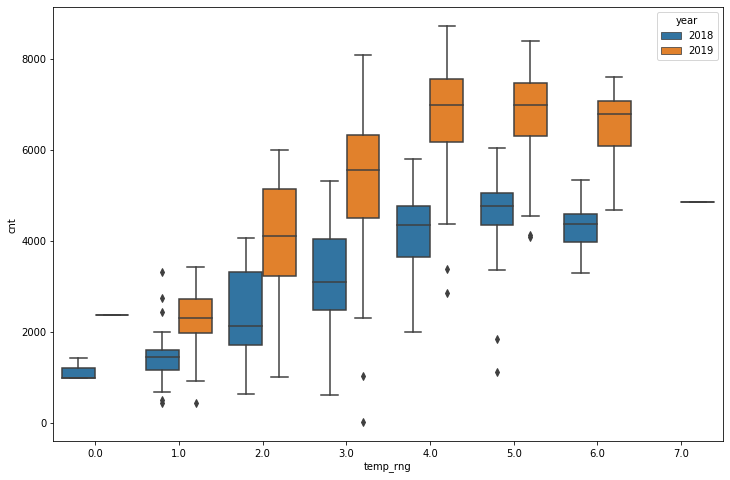

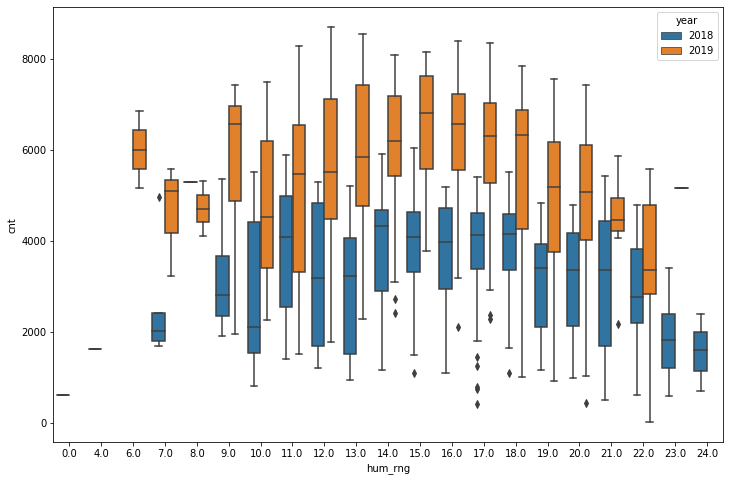

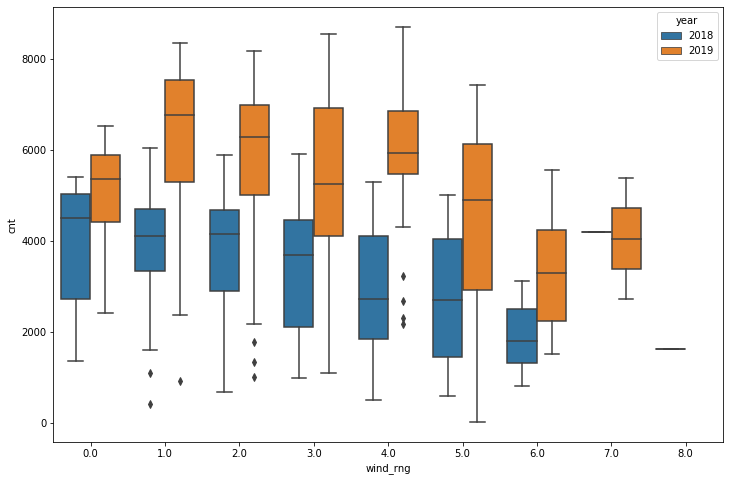

In [2154]:
data = df01[['month_name','day','daytype','weather','season','cnt','year','casual','temp_rng','hum_rng','wind_rng']]
for column in data.columns:
    if column not in ('cnt','year'):  
        plt.figure(figsize=(12,8))
        sns.boxplot(data = data, y = 'cnt',x = column, hue="year")
        if column in ('day','daytype'):
            plt.figure(figsize=(12,8))
            sns.boxplot(data = data, y = 'casual',x = column, hue="year")
        plt.show()

## Inferences 
 - as clrearly visible the weather and season across the year affects the ridership similarly across the year 2018 vs 2019. 
 - the higher %tage in 2019 is tagged to increase in the base ridership in 2019 wrt 2018.
 - Over the months the variation in ridership follow same pattens probably due to similar climatic conditions. 
 - Casual riders are showing a big jump during the weekends and also Monday(interestingly!).
 - When the temp falls between 2-10 degres the bike ridership drops significantly. Optimal seems to be T20-30C
 - at higher windspeed rider count seems to be decreasing compared to lower windspeed

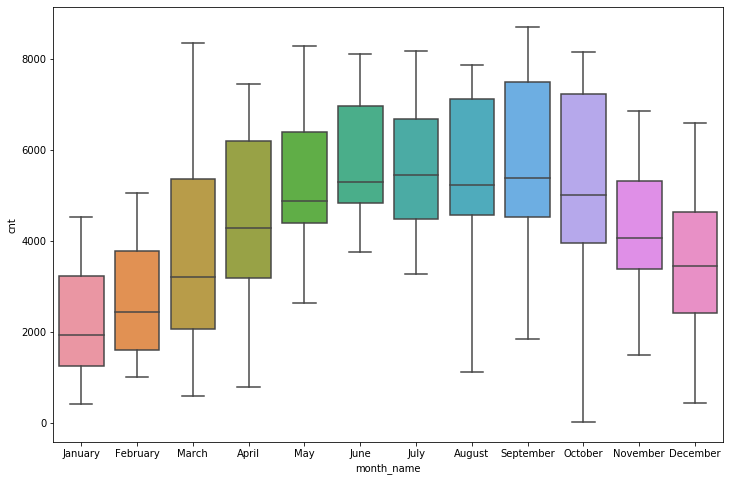

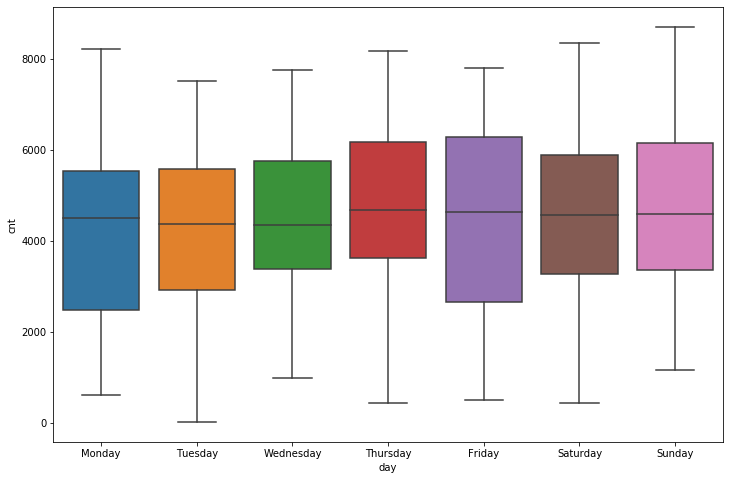

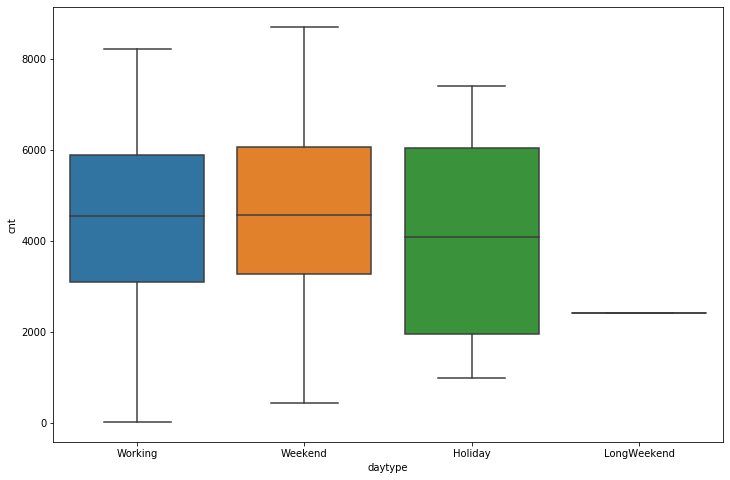

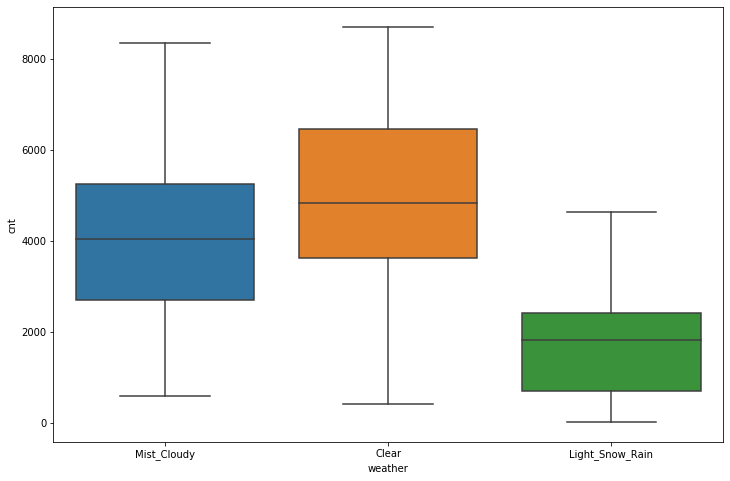

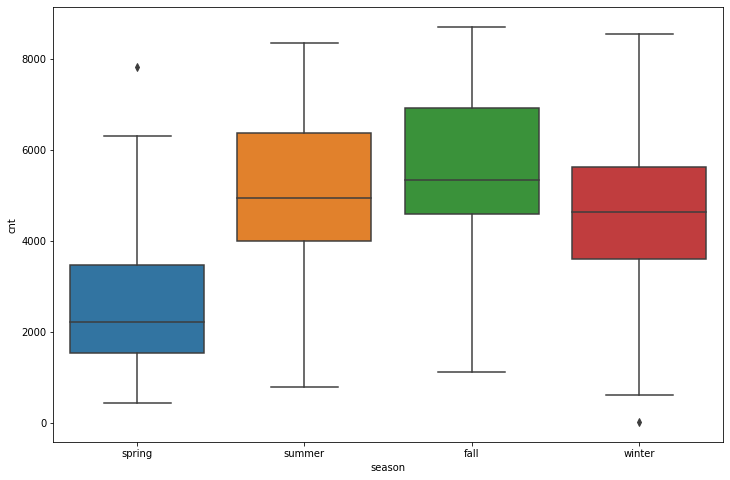

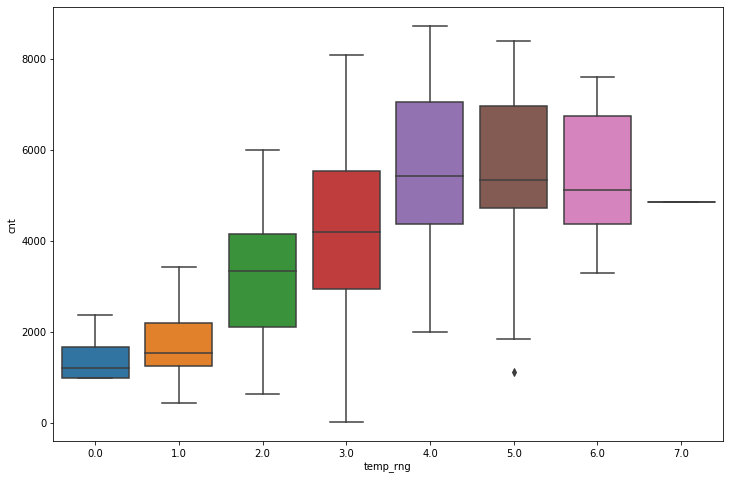

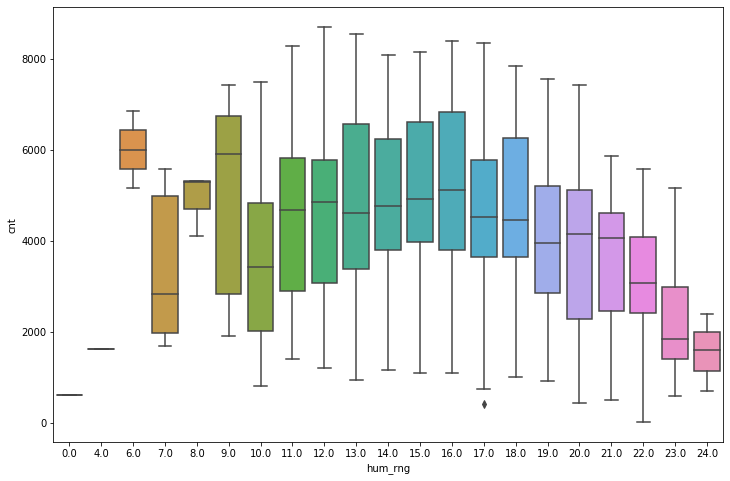

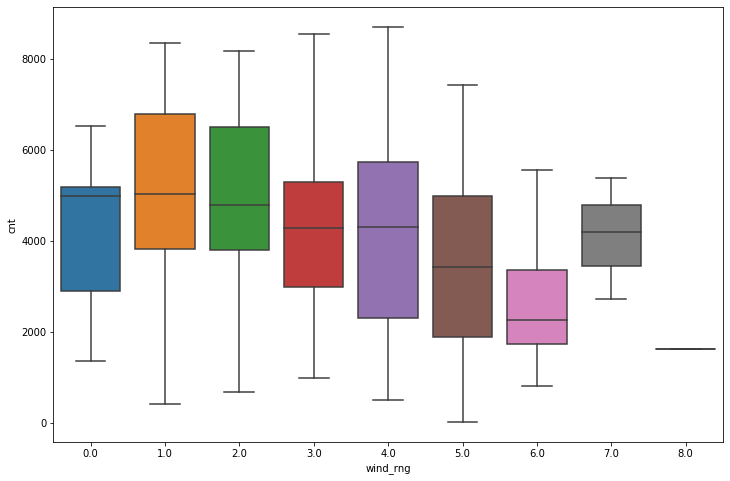

In [2155]:
# Box plot to see how the data is disctributed across categorical variables wrt the target variables.
data = df01[['month_name','day','daytype','weather','season','temp_rng','cnt','year','hum_rng','wind_rng']]
for column in data.columns:
    if column not in ('cnt','year'):  
        plt.figure(figsize=(12,8))
        sns.boxplot(data = data, y = 'cnt',x = column)
        plt.show()

## Inferences :
 - People ride more during Summer and Fall followed by Winter and lowest usage is recorded in Spring. 
 - Temp range T0-10 sees least usage however T20-30 seems most optimal for ridership
 - If the weather is clear then usgae is recorded maximum followed by when the weather is partly misty / cloudy. However in case of snow / thunderstorm the ridership is least (also to note , the snow and thunderstorm days are also less compared to the others. 
 - Holiays typically attract riders

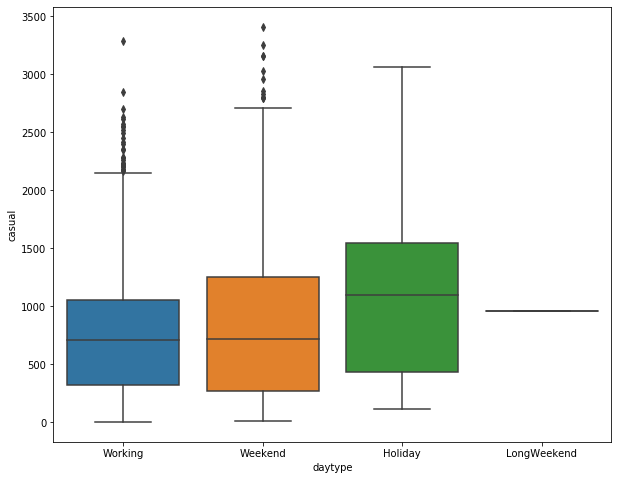

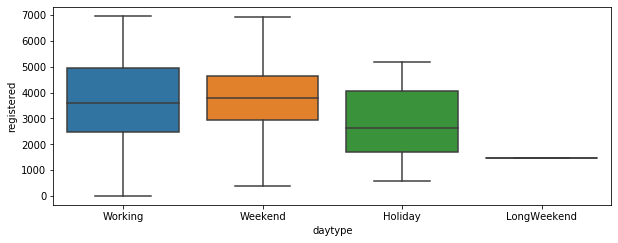

In [2110]:
## Check the casual and registered users behaviour wrt to type of the day ie. weekend/weekday and Holiday !
plt.figure(figsize=(10,8))
d=df01[['daytype','weather','casual','registered']]
plt.subplot(1,1,1)
sns.boxplot(data=d,x='daytype', y ='casual')
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.boxplot(data=d,x='daytype', y ='registered')
plt.show()

## Inference(s)
    - This is worth noting that during the Holidays & Weekends the surge in the ridership is coming from the casual riders. 

In [2156]:
# Realised we just have one record in the whole data set with daytype=='LongWeekend' category. 
# ie. Either Friday or Monday as holiday let's keep it to Holiday and not introduce any new cat.
# so as not to introduce more cat

df01[df01.daytype=='LongWeekend']

,instant,dteday,month_name,day,year,day_of_yr,day_since_strt,daytype,temp,atemp,...,weather,season,windspeed,casual,registered,cnt,percvd_tmp_diff,temp_rng,wind_rng,hum_rng
690,691,2019-11-22,November,Friday,2019,325,690,LongWeekend,13.94,17.51855,...,Clear,winter,3.542344,955,1470,2425,0.083218,2.0,0.0,14.0


In [2157]:
df01.loc[df01['daytype']=='LongWeekend','daytype'] = 'Holiday'

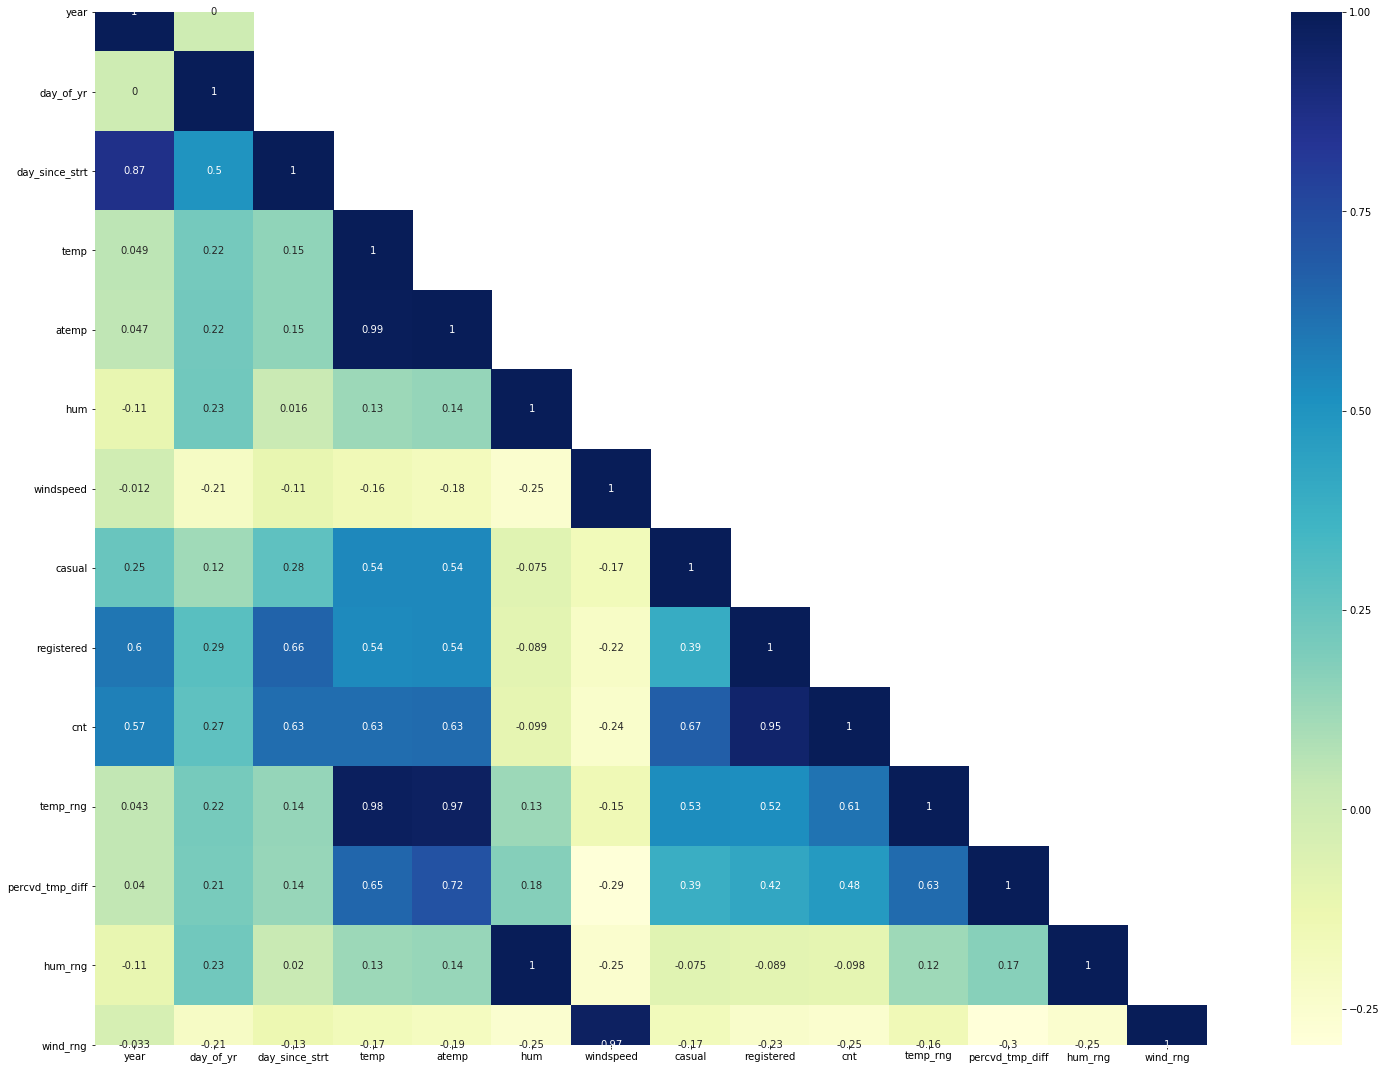

In [2158]:
# Let's check once the correlation coefficients to see which variables are highly correlated before starting the model build
cor_mat=df01[:][['dteday', 'month_name', 'day', 'year', 'day_of_yr',
       'day_since_strt', 'daytype', 'temp', 'atemp', 'hum', 'weather',
       'season', 'windspeed', 'casual', 'registered', 'cnt', 'temp_rng',
       'percvd_tmp_diff', 'hum_rng', 'wind_rng']].corr()
mask =np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(30,19))
sns.heatmap(data =cor_mat, mask=mask, square=True, annot=True,cbar=True,cmap='YlGnBu')
plt.show()

 ## Inferences (wrt Target - cnt)
    - atemp and temp are perfectly correlated however atemp seems to be a slighlty better predictor for cnt as seen above
    - temp is +ve correlated with cnt
    - Registered and cnt are highly +ve corelated as seemed obvious 
    - Perceived temp diff between actual and felt is -vely correlated to the riders cnt
    - Since the start there is growth in the registered users hence +vely correlated with Day_since_start
    - Windpeed range is -ve corelated to cnt
    - Continuous variable temp, windspeed and hum are almost perfectly correlated with their respective binned range variable (as expeted)
    - Count is highly correlated with registered user count however not that significantly correlated with casual usr counts

## Handling Categorical variables using dummy 

In [2314]:
_season = pd.get_dummies(df01['season'], drop_first = True)
_weather = pd.get_dummies(df01['weather'], drop_first = False)
## we want to retain clear weather predictor given +ve correlation and hence dropping self identified col - Light_Snow_Rain
_weather = _weather.drop(columns=['Light_Snow_Rain']) 
_daytype = pd.get_dummies(df01['daytype'], drop_first = True)

In [2315]:
df02=pd.concat([df01,_season,_weather,_daytype], axis=1)

In [2316]:
# Dropping the columns post dummy creation 
# I am also dropping Months and Days as they are factored in the feature variables 
# (Seasons) and (Weekend and Workingday) respectively.
df02 = df02.drop(columns=['daytype','weather','season','month_name','day','year','dteday','instant'])

In [2317]:
df02.head()

,day_of_yr,day_since_strt,temp,atemp,hum,windspeed,casual,registered,cnt,percvd_tmp_diff,temp_rng,wind_rng,hum_rng,spring,summer,winter,Clear,Mist_Cloudy,Weekend,Working
0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,985,0.679517,2.0,2.0,20.0,1,0,0,0,1,0,1
1,1,1,14.902598,17.68695,69.6087,16.652113,131,670,801,-0.774762,2.0,4.0,17.0,1,0,0,0,1,0,1
2,2,2,8.050924,9.47025,43.7273,16.636703,120,1229,1349,-1.933077,1.0,4.0,10.0,1,0,0,1,0,0,1
3,3,3,8.200000,10.60610,59.0435,10.739832,108,1454,1562,-1.136667,1.0,2.0,14.0,1,0,0,1,0,0,1
4,4,4,9.305237,11.46350,43.6957,12.522300,82,1518,1600,-1.357033,1.0,3.0,10.0,1,0,0,1,0,0,1


## Train Test Split 

In [2318]:
from sklearn.model_selection import train_test_split

In [2319]:
np.random.seed(0)
df_train,df_test = train_test_split(df02,train_size=.7,test_size=.3,random_state=100)

In [2320]:
print('Train_count = {} | Test_count = {}'.format(round(df_train.shape[0]/df02.shape[0],1), df_test.shape[0]/df02.shape[0]))

Train_count = 0.7 | Test_count = 0.3


## Standardising and Scaling of variables 
 - following numerical variable have various mensurement scales so for better interpretation lets scale to standardise 
  - atemp
  - temp
  - hum
  - windspeed
  - casual	
  - registered	
  - cnt
  - day_since_strt
  - percvd_tmp_diff
NB: Scaling the variable after Train - Test Split !

In [2321]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2322]:
num_vars = ['temp','cnt','atemp','hum','windspeed','casual','registered','day_since_strt','percvd_tmp_diff']
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables 
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

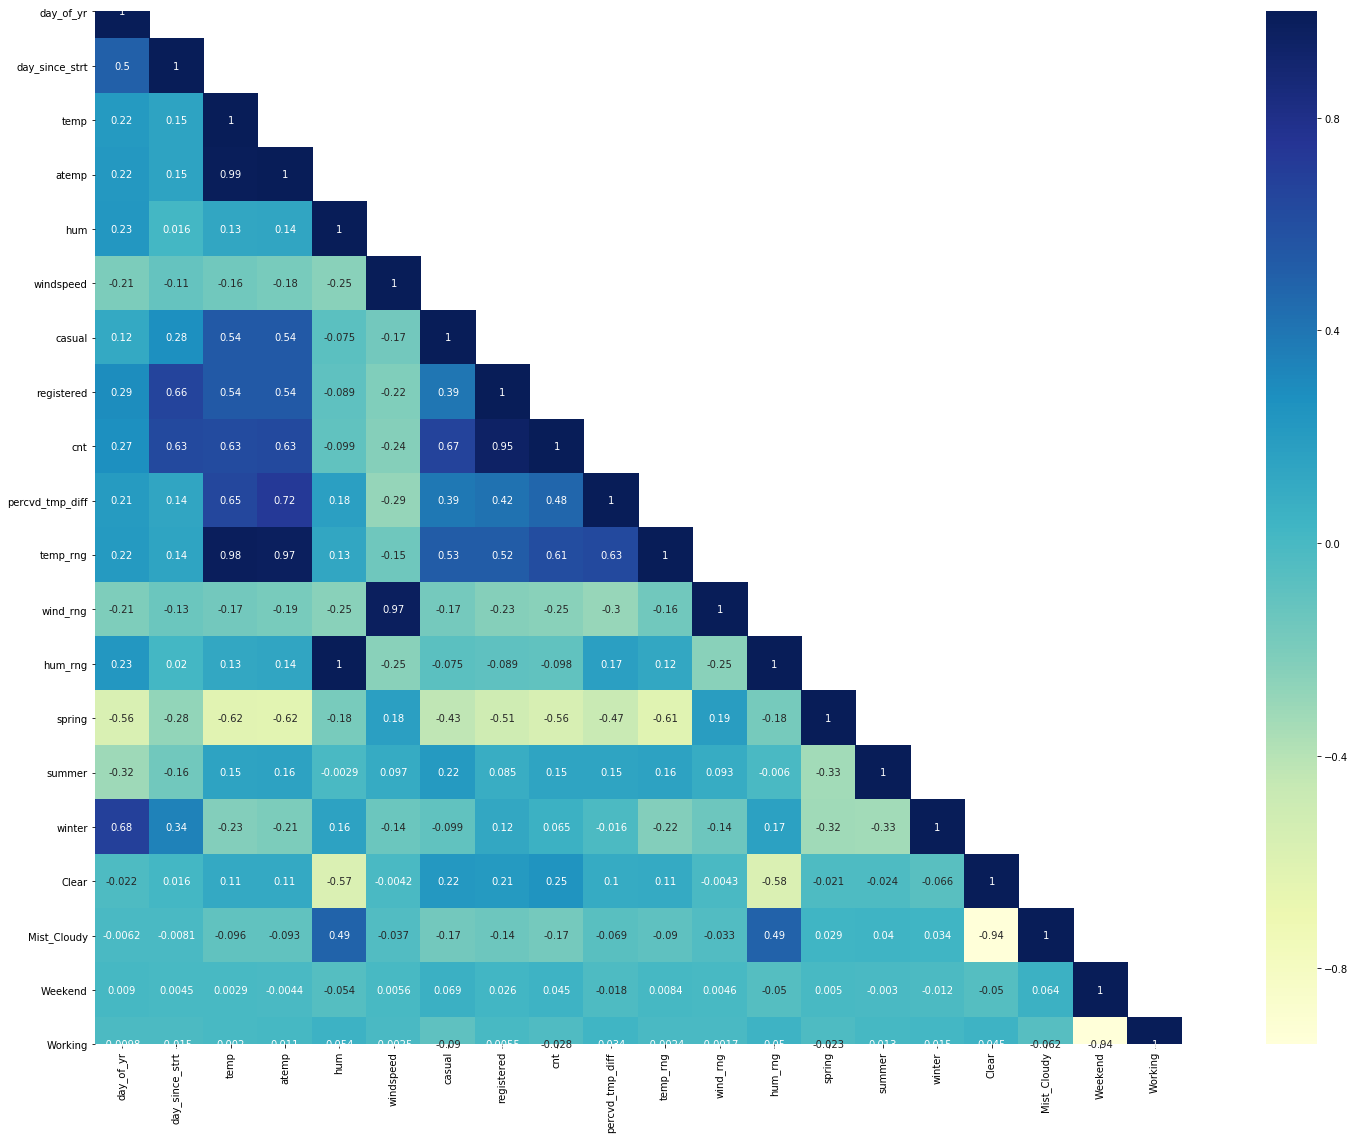

In [2231]:
cor_mat=df02[:].corr()
mask =np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(30,19))
sns.heatmap(data =cor_mat, mask=mask, square=True, annot=True,cbar=True,cmap='YlGnBu')
plt.show()

### Picking up features between based variable and derrived variables :

1. Picking Hum_rng btw hum_rng and hum as they seemed to be perfectly correlated 
2. picking wind_rng btw windspeed and wind_rng as they are perfectly correlated
3. picking atemp between temp and atemp as they are perectly correlated 
4. Picking cnt btw registerd and cnt as they are +ve 95 correlated
5. Registered users are almost perfectly co-rrelated with Cnt however the Casual rides count is not. Lets consider the impact of casual rider patterns to over all cnt.

## Dividing into X and y sets for the model building

## MODEL 1

In [2323]:
y_train = df_train.pop('cnt')

In [2243]:
# Starting with the 13 predictors
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual', 'percvd_tmp_diff',
                    'spring', 'summer', 'winter', 'Clear', 'Mist_Cloudy','Weekend', 'Working']]

In [2244]:
X_train = sm.add_constant(X_train)
lrm_1 = sm.OLS(y_train, X_train).fit()
lrm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     195.2
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          1.82e-185
Time:                        13:24:32   Log-Likelihood:                 500.32
No. Observations:                 510   AIC:                            -972.6
Df Residuals:                     496   BIC:                            -913.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0850      0.056     -1.516      0.130      -0.195       0.025
day_since_strt      0.3973      0.016     24.217      0.000       0.365       0.430
atemp               0.4247      0.048      8.792      0.000       0.330       0.520
hum                -0.1391      0.038     -3.620      0.000      -0.215      -0.064
windspeed          -0.1511      0.027     -5.548      0.000      -0.205      -0.098
casual              0.2504      0.026      9.648      0.000       0.199       0.301
percvd_tmp_diff    -0.0891      0.068     -1.317      0.188      -0.222       0.044
spring             -0.0008      0.020     -0.042      0.967      -0.041       0.039
summer              0.0703      0.014      4.962      0.000       0.042       0.098
winter              0.0193      0.017      1.125      0.261      -0.014       0.053
Clear               0.1960      0.027      7.154      0.000       0.142       0.250
Mist_Cloudy         0.1569      0.026      6.090      0.000       0.106       0.207
Weekend             0.1006      0.029      3.459      0.001       0.043       0.158
Working             0.0933      0.028      3.288      0.001       0.038       0.149
==============================================================================
Omnibus:                       81.932   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.666
Skew:                          -0.945   Prob(JB):                     1.42e-32
Kurtosis:                       4.826   Cond. No.                         36.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2245]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
10,Clear,10.58
12,Weekend,9.97
13,Working,9.97
11,Mist_Cloudy,9.01
2,atemp,6.33
7,spring,4.56
9,winter,3.33
6,percvd_tmp_diff,2.85
8,summer,2.24
3,hum,1.89


### Model 1 - assessment :
1. R2 is at c.83.8% (with Adj. R-squared 83.2%)
2. spring is not being a significant predictors with PValue = 0.967
3. Clear,Mist_Cloud | Working,Weekend, are respectivity having high VIF ie. co-linearity probably because these predictors are  complimentry to each other 

In the next model lets drop this Predictor ,<b> winter </b> and rebuild the model and analyse. 

## Model 2

In [2246]:
# - drop spring 
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual', 'percvd_tmp_diff',
                    'summer', 'winter', 'Clear', 'Mist_Cloudy','Weekend', 'Working']]

In [2247]:
X_train = sm.add_constant(X_train)
lrm_2 = sm.OLS(y_train, X_train).fit()
lrm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     211.9
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          1.22e-186
Time:                        13:25:08   Log-Likelihood:                 500.32
No. Observations:                 510   AIC:                            -974.6
Df Residuals:                     497   BIC:                            -919.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0857      0.053     -1.617      0.106      -0.190       0.018
day_since_strt      0.3974      0.016     24.357      0.000       0.365       0.429
atemp               0.4261      0.034     12.472      0.000       0.359       0.493
hum                -0.1392      0.038     -3.634      0.000      -0.214      -0.064
windspeed          -0.1513      0.027     -5.618      0.000      -0.204      -0.098
casual              0.2504      0.026      9.658      0.000       0.199       0.301
percvd_tmp_diff    -0.0899      0.065     -1.388      0.166      -0.217       0.037
summer              0.0707      0.011      6.680      0.000       0.050       0.092
winter              0.0199      0.012      1.716      0.087      -0.003       0.043
Clear               0.1960      0.027      7.168      0.000       0.142       0.250
Mist_Cloudy         0.1568      0.026      6.098      0.000       0.106       0.207
Weekend             0.1006      0.029      3.469      0.001       0.044       0.158
Working             0.0934      0.028      3.297      0.001       0.038       0.149
==============================================================================
Omnibus:                       81.943   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.716
Skew:                          -0.945   Prob(JB):                     1.38e-32
Kurtosis:                       4.826   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2248]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
9,Clear,10.55
11,Weekend,9.94
12,Working,9.94
10,Mist_Cloudy,9.00
2,atemp,3.17
6,percvd_tmp_diff,2.62
3,hum,1.88
5,casual,1.72
8,winter,1.51
1,day_since_strt,1.33


### Model 2 : assessment
1. R2 didn't drop similar to previous (model1) output at c.83.7% and Adjusted R2 also didnt drop much
2. Now we see season winter becoming insignificat as the P Value of 0.087
3. Veriance Inflation Factor for weekend and Working is at same c.9.90 (indicating multi-collinearity).For now we keep it.

In the next model we will remove <b> winter </b> Predictor and rebuild it. 

## Model 3

In [2249]:
# - winter
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual', 'percvd_tmp_diff',
                    'summer', 'Clear', 'Mist_Cloudy','Weekend', 'Working']]

In [2250]:
X_train = sm.add_constant(X_train)
lrm_3 = sm.OLS(y_train, X_train).fit()
lrm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.0
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          3.40e-187
Time:                        13:26:25   Log-Likelihood:                 498.82
No. Observations:                 510   AIC:                            -973.6
Df Residuals:                     498   BIC:                            -922.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0896      0.053     -1.689      0.092      -0.194       0.015
day_since_strt      0.4072      0.015     26.598      0.000       0.377       0.437
atemp               0.4047      0.032     12.704      0.000       0.342       0.467
hum                -0.1272      0.038     -3.370      0.001      -0.201      -0.053
windspeed          -0.1510      0.027     -5.595      0.000      -0.204      -0.098
casual              0.2522      0.026      9.718      0.000       0.201       0.303
percvd_tmp_diff    -0.0646      0.063     -1.021      0.308      -0.189       0.060
summer              0.0657      0.010      6.444      0.000       0.046       0.086
Clear               0.1928      0.027      7.053      0.000       0.139       0.246
Mist_Cloudy         0.1525      0.026      5.946      0.000       0.102       0.203
Weekend             0.1010      0.029      3.476      0.001       0.044       0.158
Working             0.0943      0.028      3.324      0.001       0.039       0.150
==============================================================================
Omnibus:                       85.137   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.769
Skew:                          -0.974   Prob(JB):                     4.07e-34
Kurtosis:                       4.856   Cond. No.                         31.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2251]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
8,Clear,10.50
10,Weekend,9.94
11,Working,9.94
9,Mist_Cloudy,8.91
2,atemp,2.75
6,percvd_tmp_diff,2.49
3,hum,1.82
5,casual,1.72
4,windspeed,1.26
1,day_since_strt,1.17


### Model 3 : assessment
1. R2 dropped slightly to 83.6% Adjusted R2 didn't drop. 
2. Veriance Inflation Factor for weekend and Working is at same c.9.8+ (indicating multi-collinearity)
3. Variables seems significant predictor but lets deal with multi-collinearity
In the next model we will remove <b> percvd_tmp_diff </b>Predictor and rebuild it. 

## Model 4

In [2254]:
# -percvd_tmp_diff
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual',
                    'summer', 'Clear', 'Mist_Cloudy','Weekend', 'Working']]

In [2255]:
X_train = sm.add_constant(X_train)
lrm_4 = sm.OLS(y_train, X_train).fit()
lrm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     252.9
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          3.50e-188
Time:                        13:27:44   Log-Likelihood:                 498.28
No. Observations:                 510   AIC:                            -974.6
Df Residuals:                     499   BIC:                            -928.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0987      0.052     -1.887      0.060      -0.201       0.004
day_since_strt     0.4059      0.015     26.599      0.000       0.376       0.436
atemp              0.3835      0.024     15.849      0.000       0.336       0.431
hum               -0.1318      0.037     -3.520      0.000      -0.205      -0.058
windspeed         -0.1449      0.026     -5.505      0.000      -0.197      -0.093
casual             0.2540      0.026      9.810      0.000       0.203       0.305
summer             0.0644      0.010      6.366      0.000       0.044       0.084
Clear              0.1888      0.027      6.979      0.000       0.136       0.242
Mist_Cloudy        0.1498      0.026      5.872      0.000       0.100       0.200
Weekend            0.0993      0.029      3.423      0.001       0.042       0.156
Working            0.0925      0.028      3.266      0.001       0.037       0.148
==============================================================================
Omnibus:                       86.765   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.163
Skew:                          -0.986   Prob(JB):                     4.52e-35
Kurtosis:                       4.884   Cond. No.                         30.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2256]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
7,Clear,10.29
9,Weekend,9.91
10,Working,9.90
8,Mist_Cloudy,8.82
3,hum,1.79
5,casual,1.71
2,atemp,1.59
4,windspeed,1.20
1,day_since_strt,1.16
6,summer,1.14


### Model 4 : assessment
1. R2 dropped slightly at c.83.5%
2. VIF indicate multi-collinearity at this stage between Clear, Weekend, Working anf Misty_Cloudy 

In the next model we will remove <b> Weekend </b> Predictor and rebuild it. 

## Model 5

In [2260]:
#-Weekend
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual',
                    'summer', 'Clear', 'Mist_Cloudy', 'Working']]


In [2262]:
X_train = sm.add_constant(X_train)
lrm_5 = sm.OLS(y_train, X_train).fit()
lrm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     273.8
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          6.60e-187
Time:                        13:29:57   Log-Likelihood:                 492.36
No. Observations:                 510   AIC:                            -964.7
Df Residuals:                     500   BIC:                            -922.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0011      0.044     -0.024      0.981      -0.088       0.086
day_since_strt     0.4054      0.015     26.285      0.000       0.375       0.436
atemp              0.3889      0.024     15.938      0.000       0.341       0.437
hum               -0.1385      0.038     -3.662      0.000      -0.213      -0.064
windspeed         -0.1461      0.027     -5.489      0.000      -0.198      -0.094
casual             0.2527      0.026      9.655      0.000       0.201       0.304
summer             0.0656      0.010      6.425      0.000       0.046       0.086
Clear              0.1843      0.027      6.747      0.000       0.131       0.238
Mist_Cloudy        0.1476      0.026      5.728      0.000       0.097       0.198
Working            0.0007      0.009      0.076      0.939      -0.017       0.019
==============================================================================
Omnibus:                       94.933   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.450
Skew:                          -1.026   Prob(JB):                     4.41e-42
Kurtosis:                       5.180   Cond. No.                         26.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2263]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
7,Clear,10.27
8,Mist_Cloudy,8.82
3,hum,1.79
5,casual,1.71
2,atemp,1.58
4,windspeed,1.20
1,day_since_strt,1.16
6,summer,1.14
9,Working,1.02


### Model 5 : Assessment 
R2 drops slightly at - 83.2%

<b> Working </b> Predictor is found to be insignificant as all the Pvalues 0.939. Lets drop it.

VIF for Clear and Mist_Cloudy Predictor are all >5 which means multi-collinearity.Will handle too.       

## Model 6

In [2324]:
# - Working
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual',
                    'summer', 'Clear', 'Mist_Cloudy']]

In [2325]:
X_train = sm.add_constant(X_train)
lrm_6 = sm.OLS(y_train, X_train).fit()
lrm_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     308.7
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          3.65e-188
Time:                        14:27:14   Log-Likelihood:                 492.36
No. Observations:                 510   AIC:                            -966.7
Df Residuals:                     501   BIC:                            -928.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0008      0.044     -0.017      0.986      -0.087       0.086
day_since_strt     0.4054      0.015     26.327      0.000       0.375       0.436
atemp              0.3890      0.024     15.964      0.000       0.341       0.437
hum               -0.1383      0.038     -3.668      0.000      -0.212      -0.064
windspeed         -0.1461      0.027     -5.495      0.000      -0.198      -0.094
casual             0.2524      0.026      9.716      0.000       0.201       0.303
summer             0.0657      0.010      6.447      0.000       0.046       0.086
Clear              0.1844      0.027      6.763      0.000       0.131       0.238
Mist_Cloudy        0.1476      0.026      5.734      0.000       0.097       0.198
==============================================================================
Omnibus:                       95.178   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.242
Skew:                          -1.028   Prob(JB):                     2.97e-42
Kurtosis:                       5.185   Cond. No.                         24.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2326]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
7,Clear,10.25
8,Mist_Cloudy,8.82
3,hum,1.78
5,casual,1.69
2,atemp,1.58
4,windspeed,1.20
1,day_since_strt,1.16
6,summer,1.13


### Model 6 : Assessment 
R2 drops slightly at - 83.1% and a slight drop to Adjusted R2

All Predictor is found to be significant as all the Pvalues 0. 

VIF for Clear and Mist_Cloudy Predictor are all >5 which means multi-collinearity.Will handle now. Drop <b> Mist_Cloudy </b>       

## Model 7

In [2301]:
# - Mist_Cloudy
X_train = df_train[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual','summer', 'Clear']]

In [2302]:
X_train = sm.add_constant(X_train)
lrm_7 = sm.OLS(y_train, X_train).fit()
lrm_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     327.3
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          1.53e-182
Time:                        14:20:06   Log-Likelihood:                 476.15
No. Observations:                 510   AIC:                            -936.3
Df Residuals:                     502   BIC:                            -902.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1697      0.034      5.059      0.000       0.104       0.236
day_since_strt     0.4040      0.016     25.444      0.000       0.373       0.435
atemp              0.3866      0.025     15.389      0.000       0.337       0.436
hum               -0.1774      0.038     -4.639      0.000      -0.252      -0.102
windspeed         -0.1661      0.027     -6.113      0.000      -0.220      -0.113
casual             0.2665      0.027      9.990      0.000       0.214       0.319
summer             0.0678      0.010      6.458      0.000       0.047       0.088
Clear              0.0407      0.011      3.672      0.000       0.019       0.063
==============================================================================
Omnibus:                      102.615   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.956
Skew:                          -1.076   Prob(JB):                     2.85e-48
Kurtosis:                       5.382   Cond. No.                         19.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2303]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif[1:]

,Features,VIF
3,hum,1.72
5,casual,1.67
7,Clear,1.60
2,atemp,1.58
4,windspeed,1.18
1,day_since_strt,1.16
6,summer,1.13


## Model 7 : Assessment 
#### R2 drops at 82.0% and Adjusted R2 are 81%
#### All predictors are significant
#### All features are having Variance Inflation factor < 2

## Residual Anlysis using the 7(Train Vs Test dataset Prediction) 

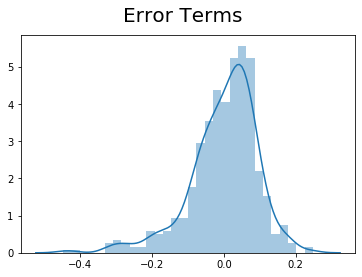

In [2313]:
# testing the model 
y_train_ = lrm_7.predict(X_train)
fig = plt.figure()
sns.distplot((y_train - y_train_), bins = 30)
fig.suptitle('Error Terms', fontsize = 20)
plt.show()

  ERROR TERMS : y Train vs y Train Prediected 

In [ ]:
num_vars = num_vars = ['temp','cnt','atemp','hum','windspeed','casual','registered','day_since_strt','percvd_tmp_diff']
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables 
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [ ]:
y_test = df_test.pop('cnt')

In [2305]:
X_test = df_test[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual','summer', 'Clear']]

In [2306]:
X_test_lrm7 = sm.add_constant(X_test)
y_pred_lrm7 = lrm_7.predict(X_test_lrm7)

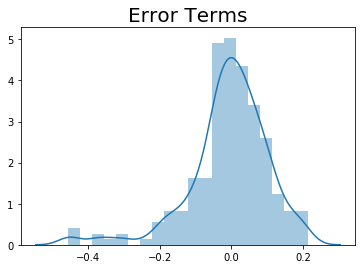

In [2308]:
plt.figure(figsize=(6,4))
sns.distplot((y_test - y_pred_lrm7), bins = 20)
plt.title('Error Terms', fontsize = 20)
plt.show()

TEST SET - ERROR TERMS : y Test vs y Test Predicted

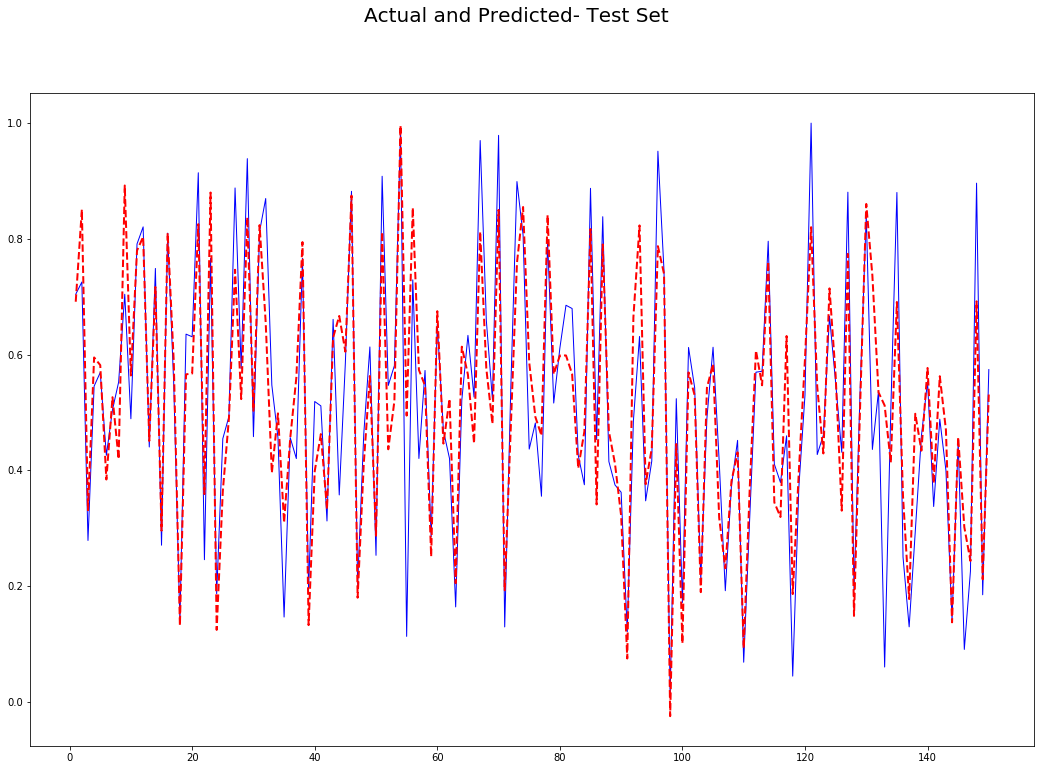

In [2344]:
#Actual vs Predicted plot for fist 150 values to see if we are able to see the overlap in the actual vs predicted values .. 
c = [i for i in range(1,151,1)]
fig = plt.figure(figsize=(18,12))
plt.plot(c,y_test[:150], color="blue", linewidth=1, linestyle="-")
plt.plot(c,y_pred_lrm7[:150], color="red",  linewidth=2,linestyle='dashed')
fig.suptitle('Actual and Predicted- Test Set', fontsize=20)
plt.show()

In [2345]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred_lrm7)

0.7717905040551115

## Residual Analysis using Model 6 ((Train Vs Test Prediction)

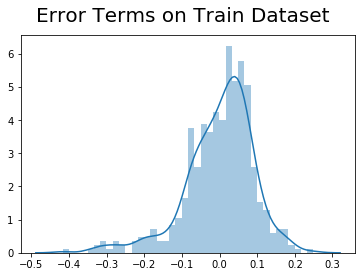

In [2327]:
y_train__ = lrm_6.predict(X_train)
fig = plt.figure()
sns.distplot((y_train - y_train__), bins = 40)
fig.suptitle('Error Terms on Train Dataset', fontsize = 20)
plt.show()

In [2328]:
num_vars = num_vars = ['temp','cnt','atemp','hum','windspeed','casual','registered','day_since_strt','percvd_tmp_diff']
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables 
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [2329]:
y_test = df_test.pop('cnt')

In [2330]:
X_test = df_test[['day_since_strt', 'atemp', 'hum', 'windspeed', 'casual',
                    'summer', 'Clear', 'Mist_Cloudy']]

In [2331]:
X_test_lrm6 = sm.add_constant(X_test)
y_pred_lrm6 = lrm_6.predict(X_test_lrm6)

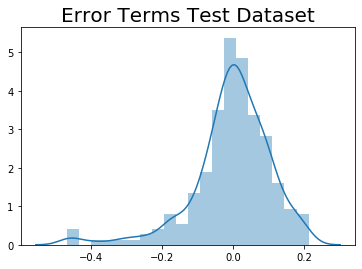

In [2332]:
plt.figure(figsize=(6,4))
sns.distplot((y_test - y_pred_lrm6), bins = 20)
plt.title('Error Terms Test Dataset', fontsize = 20)
plt.show()

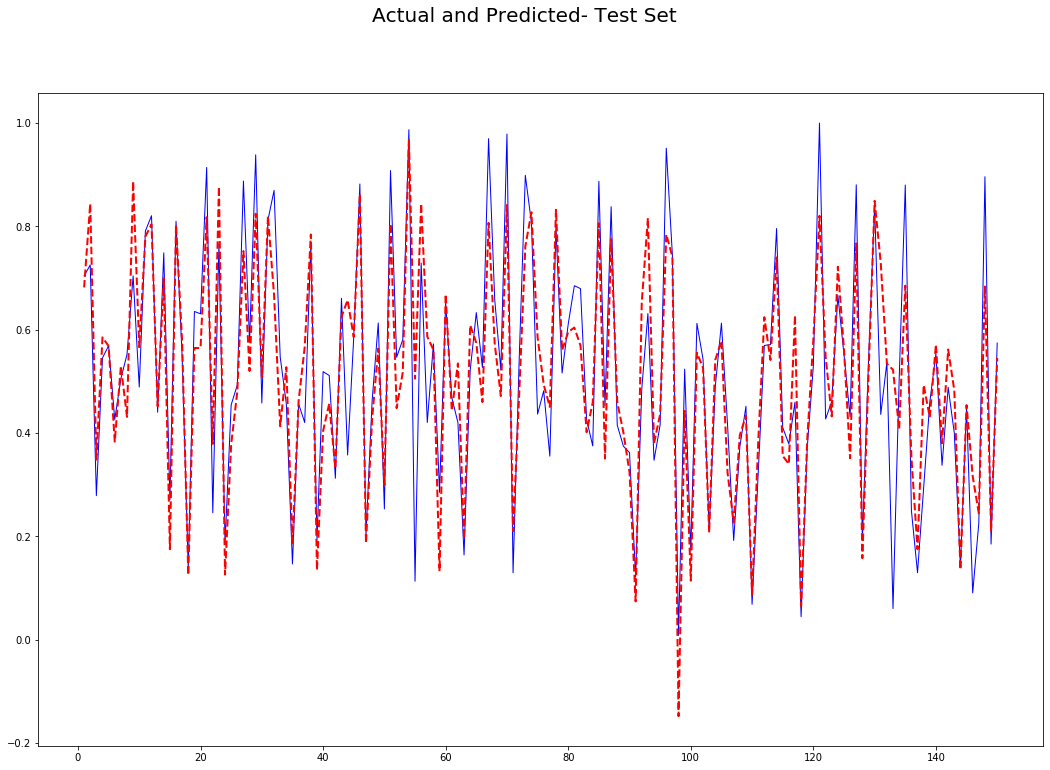

In [2333]:
#Actual vs Predicted plot for fist 150 values .. 
c = [i for i in range(1,151,1)]
fig = plt.figure(figsize=(18,12))
plt.plot(c,y_test[:150], color="blue", linewidth=1, linestyle="-")
plt.plot(c,y_pred_lrm6[:150], color="red",  linewidth=2,linestyle='dashed')
fig.suptitle('Actual and Predicted- Test Set', fontsize=20)
plt.show()

In [2334]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred_lrm6)

0.7794771549653156

# Model Intepretation and Explanation [Linear Regression Model (built using Stats Model) and Coefficients e.g (y= m1X1 + m2X2...+c)]

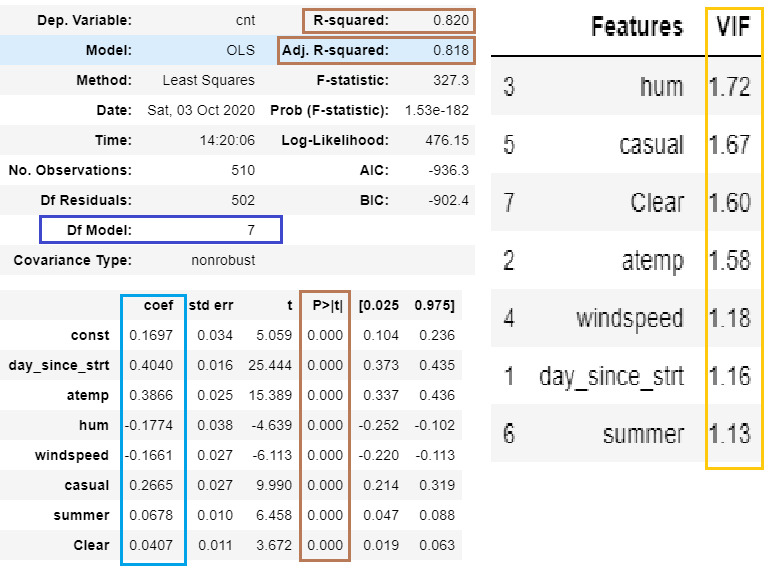

### Key Drivers of increase in cnt (Choosing Model 7)
 - Model R2 is 82% Adjusted R2 81.8 (not major Drop)
 - All predictors are significant P Values ~0
 - VIF for all the chosen predictors < 2 (indicating no multi -collinearity between predictors)
 - 7 Major predictors - with <b>day_since_start(age of the company), atemp and casual riders , season (summer) , Weathercondition (clear) have + coefficients </b> however for <b> humidity and Windspeed have -ve Coefficients </b>.
 - All positive predictor coefficients indicate that with <b> unit increase in that predictor </b> will lead to an increase of cnt by <b> coefficient*predictor </b> times
 - Temperature is key driver - ie with drop in temperature the ridership decreases by a factor of 0.38
 - In Summer season ridership goes us by 6-7%.
 - Since jan 2018 BoomBikes have been in business with each passing day they see increase in ridership and is considerable factor.
 
<b>Using Stats model (for Model7) we get a R2 82% on the Train set with 7 predictors however with Test set we get R2 to be 78 % only. I think we can use the SKlearn regression model and RFE technique to get the regression models built</b>

# -------------------------------------------------------------------------------------------------------------

# So far we have done with Manual selection of features and elimination which is time consuming. Lets use RFE to see if we can make better model

# -------------------------------------------------------------------------------------------------------------

In [2719]:
# Creating a fresh copy of the Dataframe 
df_01 = df[['instant', 'dteday','month_name','day', 'year','day_of_yr','day_since_strt','daytype', 'temp',
           'atemp', 'hum','weather','season',
           'windspeed','casual', 'registered',
           'cnt','percvd_tmp_diff','temp_rng','wind_rng','hum_rng']].copy(deep=True)

In [2720]:
df_01[df_01.daytype=='LongWeekend']
df_01.loc[df_01['daytype']=='LongWeekend','daytype'] = 'Holiday'

In [2721]:
# Dummy-fication of categorical variables 
__season = pd.get_dummies(df_01['season'], drop_first = True)
_weather = pd.get_dummies(df_01['weather'], drop_first = False)
## we want to retain clear weather predictor given +ve correlation and hence dropping self identified col - Light_Snow_Rain
__weather = _weather.drop(columns=['Light_Snow_Rain']) 
__daytype = pd.get_dummies(df_01['daytype'], drop_first = True)
__month_name = pd.get_dummies(df_01['month_name'], drop_first = True)

In [2722]:
df_02=pd.concat([df_01,__season,__weather,__daytype,__month_name], axis=1)

In [2723]:
# Dropping the columns post dummy creation 
# I am also dropping Months and Days as they are factored in the feature variables 
# (Seasons) and (Weekend and Workingday) respectively.
df_02 = df_02.drop(columns=['daytype','weather','season','month_name','day','year','dteday','instant',
                            'registered','casual','temp','temp_rng','wind_rng','hum_rng'])

In [2724]:
df_02.head()

,day_of_yr,day_since_strt,atemp,hum,windspeed,cnt,percvd_tmp_diff,spring,summer,winter,...,December,February,January,July,June,March,May,November,October,September
0,0,0,18.18125,80.5833,10.749882,985,0.679517,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,1,17.68695,69.6087,16.652113,801,-0.774762,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,2,9.47025,43.7273,16.636703,1349,-1.933077,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,3,10.60610,59.0435,10.739832,1562,-1.136667,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,4,4,11.46350,43.6957,12.522300,1600,-1.357033,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [2725]:
df_train_, df_test_ = train_test_split(df_02,train_size=.7,test_size=.3,random_state=100)

In [2726]:
df_train_.describe()

,day_of_yr,day_since_strt,atemp,hum,windspeed,cnt,percvd_tmp_diff,spring,summer,winter,...,December,February,January,July,June,March,May,November,October,September
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,182.578431,367.941176,23.493909,63.112926,12.831318,4486.382353,-0.005564,0.243137,0.245098,0.24902,...,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,0.084314,0.086275,0.086275,0.080392
std,106.196600,209.868619,8.090038,14.156632,5.291832,1952.158739,0.988660,0.429398,0.430568,0.43287,...,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,0.278131,0.281045,0.281045,0.272166
min,0.000000,0.000000,3.953480,0.000000,2.834381,22.000000,-4.020035,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,186.250000,16.603063,52.270825,9.041918,3120.000000,-0.542152,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,184.000000,372.000000,24.020400,63.437500,12.083182,4530.000000,0.215998,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,274.750000,552.750000,30.177700,73.250025,15.750879,5973.500000,0.530375,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,364.000000,728.000000,42.044800,97.041700,34.000021,8714.000000,5.694120,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2727]:
from sklearn.preprocessing import MinMaxScaler
scaler_ = MinMaxScaler()
# lets scale the numerical variables (except the dummy / categorical variable)
num_vars_ = ['cnt', 'atemp', 'hum', 'windspeed', 'percvd_tmp_diff','day_since_strt','day_of_yr']
df_train_[num_vars_] = scaler_.fit_transform(df_train_[num_vars_])

In [2728]:
df_train_.describe()

,day_of_yr,day_since_strt,atemp,hum,windspeed,cnt,percvd_tmp_diff,spring,summer,winter,...,December,February,January,July,June,March,May,November,October,September
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.501589,0.505414,0.512989,0.650369,0.320768,0.513620,0.413260,0.243137,0.245098,0.24902,...,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,0.084314,0.086275,0.086275,0.080392
std,0.291749,0.288281,0.212385,0.145882,0.169797,0.224593,0.101775,0.429398,0.430568,0.43287,...,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,0.278131,0.281045,0.281045,0.272166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.244505,0.255838,0.332086,0.538643,0.199179,0.356420,0.358022,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.505495,0.510989,0.526811,0.653714,0.296763,0.518638,0.436068,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.754808,0.759272,0.688457,0.754830,0.414447,0.684710,0.468431,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split test set in X and y variables for model building (using RFE)

In [2729]:
y_train_ = df_train_.pop('cnt')
X_train_ = df_train_

In [2730]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

## RFE

In [2762]:
lm = LinearRegression()
lm.fit(X_train_,y_train_)
rfe = RFE(lm,df_train_.columns.size-10)
rfe = rfe.fit(X_train_,y_train_)

In [2763]:
list(zip(X_train_.columns,rfe.support_,rfe.ranking_))

[('day_of_yr', True, 1),
 ('day_since_strt', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('percvd_tmp_diff', True, 1),
 ('spring', True, 1),
 ('summer', False, 7),
 ('winter', True, 1),
 ('Clear', True, 1),
 ('Mist_Cloudy', True, 1),
 ('Weekend', True, 1),
 ('Working', True, 1),
 ('August', False, 8),
 ('December', False, 5),
 ('February', False, 3),
 ('January', False, 2),
 ('July', True, 1),
 ('June', False, 10),
 ('March', False, 11),
 ('May', False, 6),
 ('November', False, 4),
 ('October', False, 9),
 ('September', True, 1)]

In [2764]:
col_=X_train_.columns[rfe.support_]
col_

Index(['day_of_yr', 'day_since_strt', 'atemp', 'hum', 'windspeed',
       'percvd_tmp_diff', 'spring', 'winter', 'Clear', 'Mist_Cloudy',
       'Weekend', 'Working', 'July', 'September'],
      dtype='object')

In [2765]:
X_train_.columns[~rfe.support_]

Index(['summer', 'August', 'December', 'February', 'January', 'June', 'March',
       'May', 'November', 'October'],
      dtype='object')

In [2766]:
## Getting detailed stats using Stats model 

In [2767]:
X_train_rfe_ = X_train_[col_]
X_train_rfe_ = sm.add_constant(X_train_rfe_)
lm1_ = sm.OLS(y_train_,X_train_rfe_).fit()
lm1_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     182.6
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          4.02e-185
Time:                        08:50:07   Log-Likelihood:                 502.25
No. Observations:                 510   AIC:                            -974.5
Df Residuals:                     495   BIC:                            -911.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0315      0.055      0.570      0.569      -0.077       0.140
day_of_yr          -0.2718      0.026    -10.452      0.000      -0.323      -0.221
day_since_strt      0.4620      0.016     28.041      0.000       0.430       0.494
atemp               0.5517      0.043     12.886      0.000       0.468       0.636
hum                -0.1459      0.039     -3.780      0.000      -0.222      -0.070
windspeed          -0.1653      0.027     -6.228      0.000      -0.217      -0.113
percvd_tmp_diff    -0.1069      0.065     -1.648      0.100      -0.234       0.021
spring             -0.1161      0.015     -7.554      0.000      -0.146      -0.086
winter              0.0706      0.017      4.074      0.000       0.037       0.105
Clear               0.2459      0.027      9.071      0.000       0.193       0.299
Mist_Cloudy         0.1858      0.026      7.264      0.000       0.136       0.236
Weekend             0.1031      0.029      3.550      0.000       0.046       0.160
Working             0.0838      0.028      2.956      0.003       0.028       0.140
July               -0.0770      0.017     -4.427      0.000      -0.111      -0.043
September           0.0666      0.016      4.119      0.000       0.035       0.098
==============================================================================
Omnibus:                       60.385   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.707
Skew:                          -0.627   Prob(JB):                     1.03e-31
Kurtosis:                       5.267   Cond. No.                         34.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2768]:
X_train_rfe_= X_train_rfe_.drop(['const'],axis=1)

In [2769]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_.values, i) for i in range(X_train_rfe_.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,percvd_tmp_diff,45.25
2,atemp,34.15
3,hum,27.69
11,Working,25.36
8,Clear,17.70
0,day_of_yr,13.68
9,Mist_Cloudy,10.00
10,Weekend,9.97
1,day_since_strt,5.52
4,windspeed,4.66


In [2771]:
# from previous analysis we need to drop a few additional columns 
X_train_01 = X_train_rfe_.drop(["percvd_tmp_diff","Working","Mist_Cloudy",'hum'], axis = 1)

In [2772]:
X_train_lm02 = sm.add_constant(X_train_01)

In [2773]:
lm2_ = sm.OLS(y_train,X_train_lm02).fit() 

In [2774]:
lm2_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     211.0
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          4.35e-172
Time:                        08:50:20   Log-Likelihood:                 460.28
No. Observations:                 510   AIC:                            -898.6
Df Residuals:                     499   BIC:                            -852.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1655      0.027      6.239      0.000       0.113       0.218
day_of_yr         -0.2785      0.028    -10.028      0.000      -0.333      -0.224
day_since_strt     0.4748      0.018     26.842      0.000       0.440       0.510
atemp              0.4810      0.035     13.643      0.000       0.412       0.550
windspeed         -0.1498      0.027     -5.563      0.000      -0.203      -0.097
spring            -0.1234      0.016     -7.485      0.000      -0.156      -0.091
winter             0.0481      0.018      2.673      0.008       0.013       0.083
Clear              0.0977      0.009     10.564      0.000       0.079       0.116
Weekend            0.0258      0.010      2.588      0.010       0.006       0.045
July              -0.0737      0.019     -3.952      0.000      -0.110      -0.037
September          0.0570      0.017      3.275      0.001       0.023       0.091
==============================================================================
Omnibus:                      102.300   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.782
Skew:                          -0.933   Prob(JB):                     1.63e-69
Kurtosis:                       6.380   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2775]:
#X_train_01= X_train_lm02.drop(['const'],axis=1)

In [2776]:
vif = pd.DataFrame()
vif['Features'] = X_train_01.columns
vif['VIF'] = [variance_inflation_factor(X_train_01.values, i) for i in range(X_train_01.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,day_of_yr,12.81
2,atemp,9.16
1,day_since_strt,5.44
5,winter,3.92
3,windspeed,3.91
6,Clear,2.72
4,spring,1.71
7,Weekend,1.36
8,July,1.33
9,September,1.26


Text(0.5, 0.98, 'Error Terms training set ')

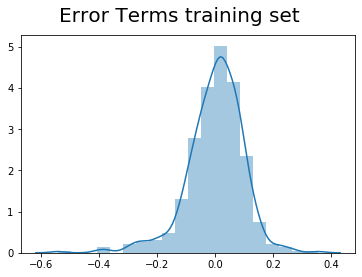

In [2717]:
# Residual Error Analysis 
y_train_pred_ = lm2_.predict(X_train_lm02)
fig = plt.figure()
sns.distplot((y_train_ - y_train_pred_), bins = 20)
fig.suptitle('Error Terms training set ', fontsize = 20)

## Making Predictions

In [2708]:
num_vars_ = ['cnt', 'atemp', 'hum', 'windspeed', 'percvd_tmp_diff','day_since_strt','day_of_yr']
df_test_[num_vars_] = scaler_.fit_transform(df_test_[num_vars_])

In [2709]:
y_test_ = df_test_.pop('cnt')
X_test_ = df_test_

In [2710]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe by dropping variables from X_test_
X_test_new = X_test_[X_train_01.columns]
# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

## Model Validation

In [2712]:
# Making predictions
y_pred_ = lm2_.predict(X_test_new)

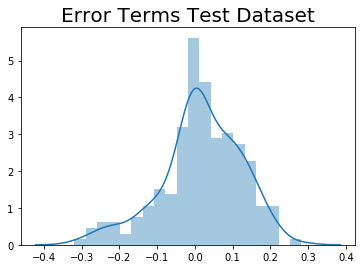

In [2713]:
plt.figure(figsize=(6,4))
sns.distplot((y_test_ - y_pred_), bins = 20)
plt.title('Error Terms Test Dataset', fontsize = 20)
plt.show()

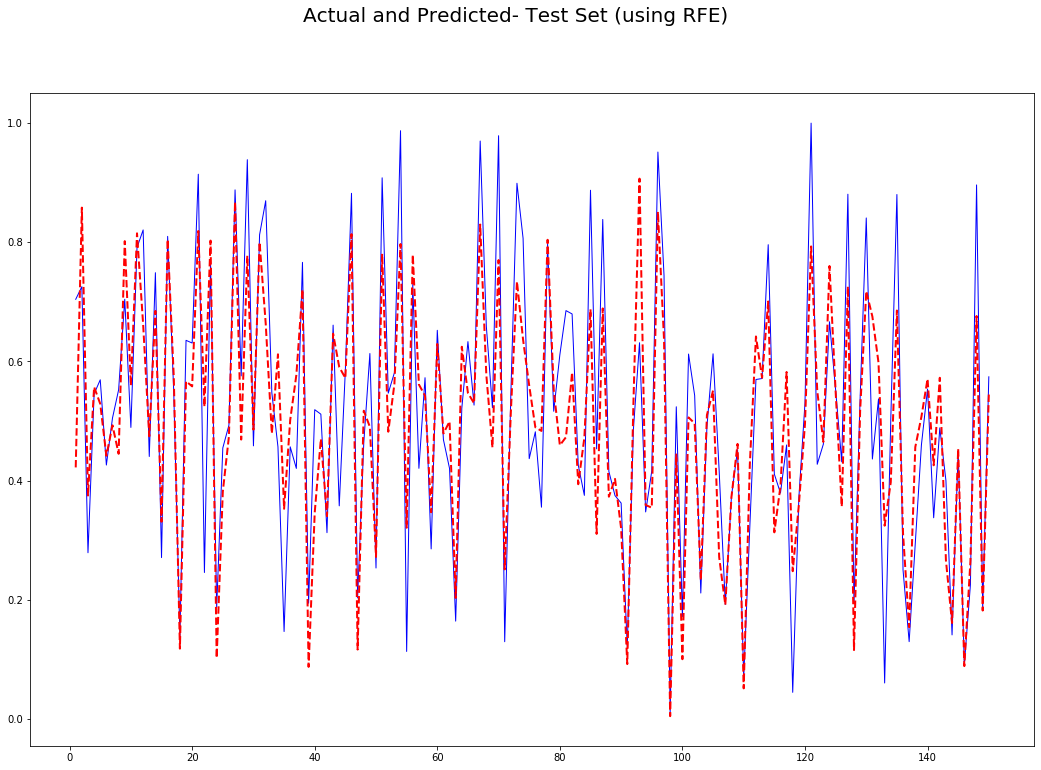

In [2715]:
#Actual vs Predicted plot for fist 150 values .. 
c = [i for i in range(1,151,1)]
fig = plt.figure(figsize=(18,12))
plt.plot(c,y_test_[:150], color="blue", linewidth=1, linestyle="-")
plt.plot(c,y_pred_[:150], color="red",  linewidth=2,linestyle='dashed')
fig.suptitle('Actual and Predicted- Test Set (using RFE)', fontsize=20)
plt.show()

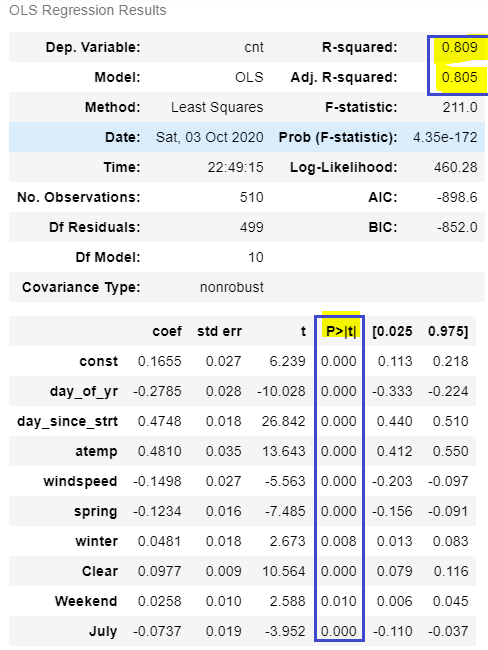

### Final model with above predictors 
 - Normal Distribution of error terms validated 
 - Adjusted R2 and Adjusted R2 is ~ 81%
 - All variables are significant
 - The r2 scores from test and predicted sets are very close i.e 81% - 80%
 - Key Predictors :
         - Day Since Start (base 01-01-2018)
         - aTemp 
         - WeatherCondition (Clear)
         - Windspeed (-Vely impacting rider count)
         - Weather - Spring is-vely impacting Rider count.
         - Also within a year later part of the year (day_of_yr) -vely impacting the ridership related to conditions / temp and etc

In [2777]:
from sklearn.metrics import r2_score
r2_score(y_test_,y_pred_)

0.7947948001101635

### SE , MSE , RMSE 

In [2784]:
error = y_test_ - y_pred_ 
se = np.sum(error**2) 
print('squared error is', se) 

mse = se/y_test_.count()
print('mean squared error is', mse) 
  
rmse = np.sqrt(mse) 
print('root mean square error is', rmse) 

squared error is 2.548918914855896
mean squared error is 0.011638899154593133
root mean square error is 0.10788372979552169


## Fitted vs. residuals plot to check homoscedasticity
#### Variance of the residuals increases with response variable magnitude.

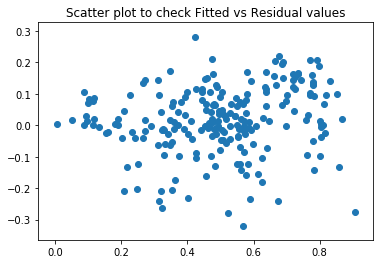

In [2793]:
x=y_pred_
y= y_test_ - y_pred_ 
plt.scatter(x,y,)
plt.title('Scatter plot to check Fitted vs Residual values')
plt.show()

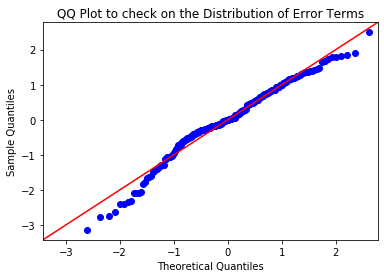

In [2818]:
Serr = y_test_ - y_pred_ 
sm.qqplot(Serr,fit=True, line='45')
plt.title('QQ Plot to check on the Distribution of Error Terms')
plt.show()